Gibbs Sampler with ArviZ Integration

True Distribution Parameters:
Mean: [ 2. -1.]
Covariance:
[[2.  0.8]
 [0.8 1.5]]

Creating Gibbs sampler for multivariate normal...

Running Gibbs sampler with multiple chains...
Sampling chain 1/4...
  Chain 1 complete: 2000 samples collected
Sampling chain 2/4...
  Chain 2 complete: 2000 samples collected
Sampling chain 3/4...
  Chain 3 complete: 2000 samples collected
Sampling chain 4/4...
  Chain 4 complete: 2000 samples collected

Sampling complete!
InferenceData groups: ['posterior', 'sample_stats']
Posterior variables: ['x', 'y']
Shape: (4, 2000) (chains × draws)
ArviZ Diagnostic Analysis

1. Summary Statistics:
----------------------------------------
    mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
x  2.007  1.405  -0.590    4.620      0.016    0.011    7415.0    7353.0   
y -1.014  1.207  -3.303    1.209      0.014    0.010    7388.0    7431.0   

   r_hat  
x    1.0  
y    1.0  

2. Creating Trace Plot...


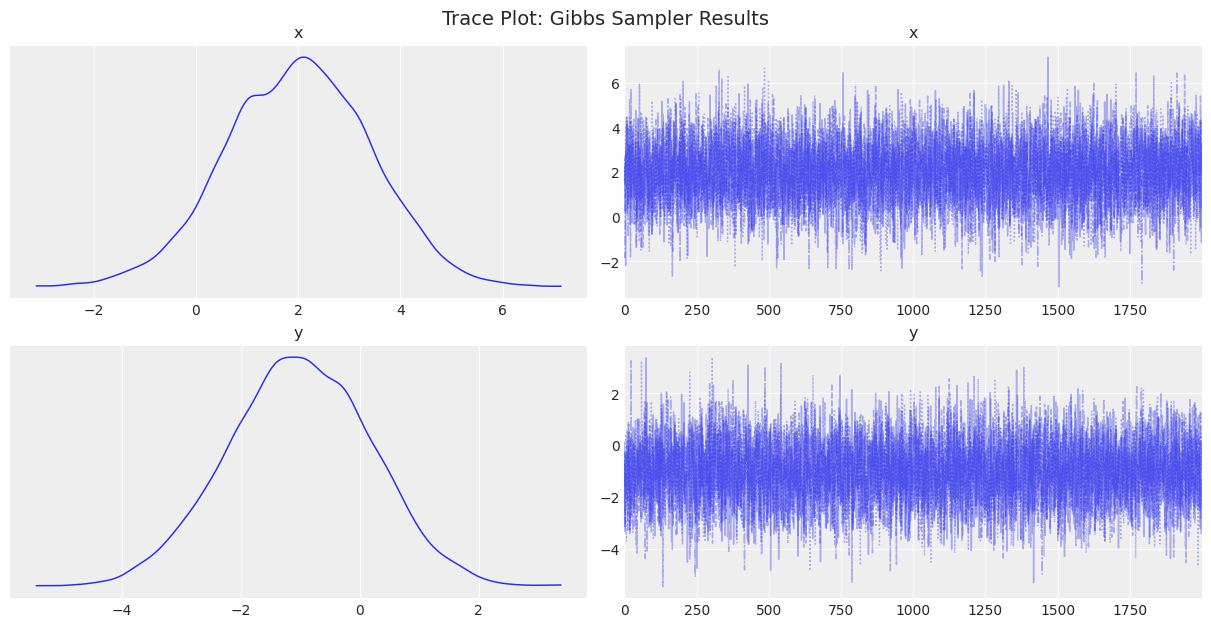


3. Creating Posterior Plot...


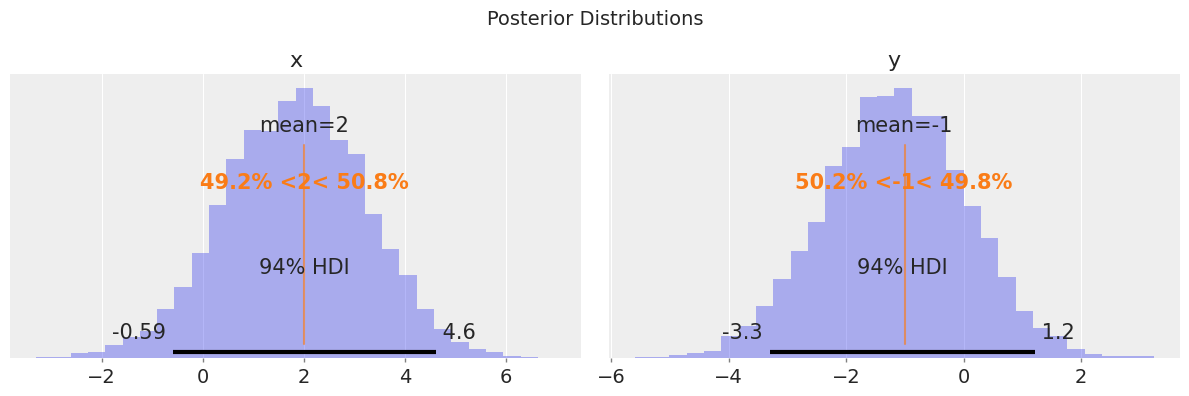


4. Creating Pair Plot...


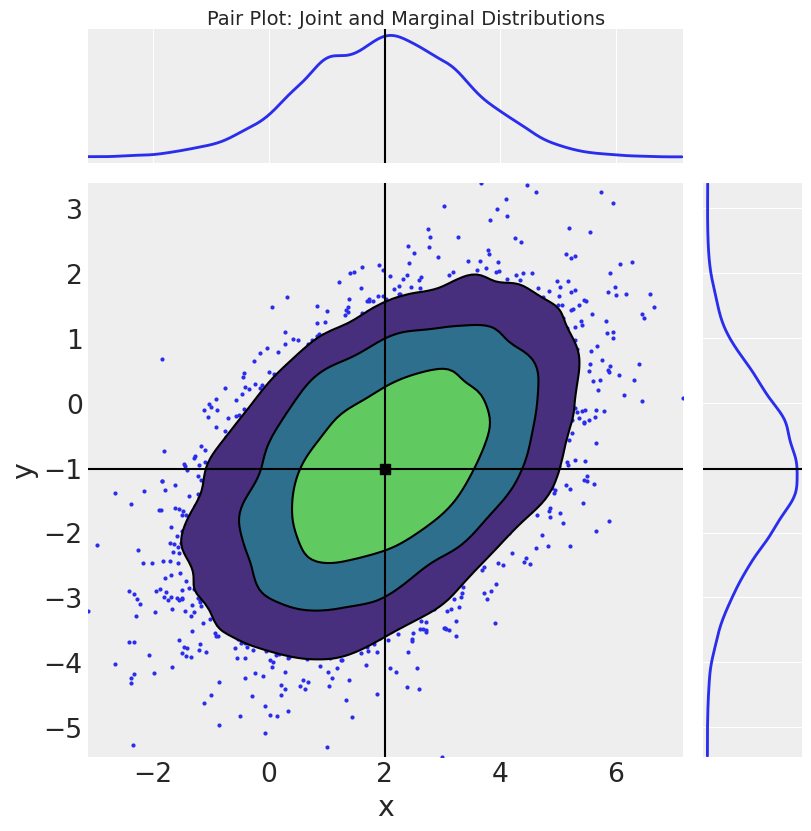


5. Creating Autocorrelation Plot...


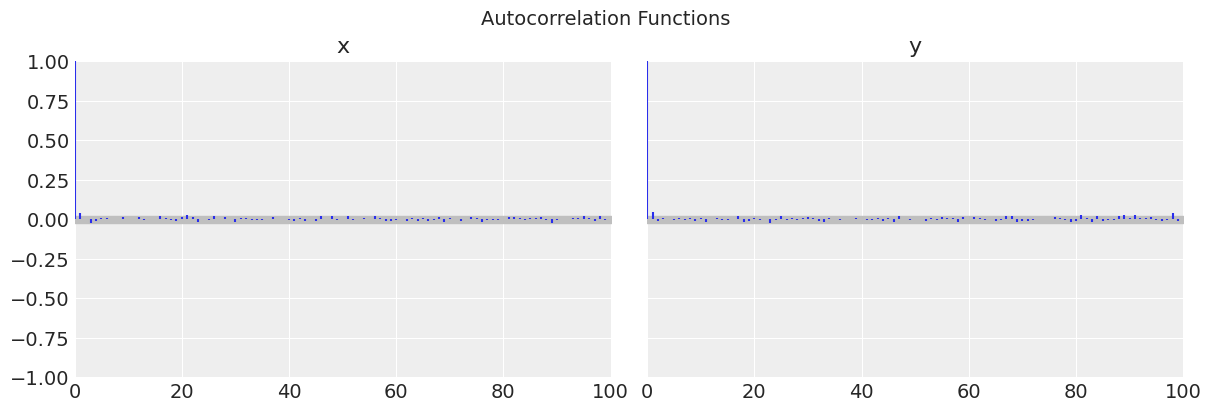


6. Creating Energy Plot...


AttributeError: 'Dataset' object has no attribute 'energy'

In [ ]:
import warnings
from typing import Optional, Tuple

import arviz as az
import matplotlib.pyplot as plt
import numpy as np

from mc_lab.gibbs_sampler_2d import GibbsSampler2D

warnings.filterwarnings("ignore")

# Set ArviZ style
az.style.use("arviz-darkgrid")


def create_mvn_gibbs_sampler(
    mean: np.ndarray, cov: np.ndarray, var_names: Tuple[str, str] = ("x", "y")
) -> GibbsSampler2D:
    """
    Create a Gibbs sampler for a 2D multivariate normal distribution.

    Parameters:
    -----------
    mean : np.ndarray
        Mean vector [mu_x, mu_y]
    cov : np.ndarray
        2x2 covariance matrix
    var_names : tuple of str
        Names for the variables

    Returns:
    --------
    sampler : GibbsSampler2D
        Configured Gibbs sampler for the MVN distribution
    """
    mu_x, mu_y = mean
    sigma_xx, sigma_yy = cov[0, 0], cov[1, 1]
    sigma_xy = cov[0, 1]

    # Conditional samplers
    def sample_x_given_y(y):
        conditional_mean = mu_x + (sigma_xy / sigma_yy) * (y - mu_y)
        conditional_var = sigma_xx - (sigma_xy**2 / sigma_yy)
        return np.random.normal(conditional_mean, np.sqrt(conditional_var))

    def sample_y_given_x(x):
        conditional_mean = mu_y + (sigma_xy / sigma_xx) * (x - mu_x)
        conditional_var = sigma_yy - (sigma_xy**2 / sigma_xx)
        return np.random.normal(conditional_mean, np.sqrt(conditional_var))

    # Log probability function for diagnostics
    def log_prob(x, y):
        state = np.array([x, y])
        diff = state - mean
        return -0.5 * (
            diff @ np.linalg.inv(cov) @ diff + np.log(2 * np.pi * np.linalg.det(cov))
        )

    return GibbsSampler2D(sample_x_given_y, sample_y_given_x, log_prob, var_names)


def demonstrate_arviz_diagnostics(
    idata: az.InferenceData,
    true_mean: Optional[np.ndarray] = None,
    true_cov: Optional[np.ndarray] = None,
):
    """
    Demonstrate various ArviZ diagnostic plots and statistics.

    Parameters:
    -----------
    idata : arviz.InferenceData
        InferenceData object from Gibbs sampling
    true_mean : np.ndarray, optional
        True mean for comparison
    true_cov : np.ndarray, optional
        True covariance for comparison
    """
    print("=" * 80)
    print("ArviZ Diagnostic Analysis")
    print("=" * 80)

    # 1. Summary statistics
    print("\n1. Summary Statistics:")
    print("-" * 40)
    summary = az.summary(idata)
    print(summary)

    # 2. Trace plot (the main request!)
    print("\n2. Creating Trace Plot...")
    az.plot_trace(
        idata,
        figsize=(12, 6),
        combined=True,
        compact=True,
        backend_kwargs={"constrained_layout": True},
    )
    plt.suptitle("Trace Plot: Gibbs Sampler Results", fontsize=14, y=1.02)
    plt.show()

    # 3. Posterior plot with reference values
    print("\n3. Creating Posterior Plot...")
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    # Get variable names
    var_names = list(idata.posterior.data_vars)

    for idx, var in enumerate(var_names):
        az.plot_posterior(
            idata,
            var_names=[var],
            ax=axes[idx],
            ref_val=true_mean[idx] if true_mean is not None else None,
            kind="hist",
            bins=30,
        )
    plt.suptitle("Posterior Distributions", fontsize=14)
    plt.tight_layout()
    plt.show()

    # 4. Pair plot
    print("\n4. Creating Pair Plot...")
    az.plot_pair(
        idata,
        figsize=(8, 8),
        kind=["scatter", "kde"],
        marginals=True,
        point_estimate="mean",
        backend_kwargs={"constrained_layout": True},
    )
    plt.suptitle("Pair Plot: Joint and Marginal Distributions", fontsize=14, y=1.02)
    plt.show()

    # 5. Autocorrelation plot
    print("\n5. Creating Autocorrelation Plot...")
    az.plot_autocorr(
        idata,
        figsize=(12, 4),
        combined=True,
        backend_kwargs={"constrained_layout": True},
    )
    plt.suptitle("Autocorrelation Functions", fontsize=14)
    plt.show()

    # 6. Energy plot (if we have log probabilities)
    if "lp" in idata.sample_stats:
        print("\n6. Creating Energy Plot...")
        az.plot_energy(idata, figsize=(10, 4))
        plt.show()

    # 7. Rank plots for convergence
    print("\n7. Creating Rank Plot...")
    az.plot_rank(idata, figsize=(12, 4), backend_kwargs={"constrained_layout": True})
    plt.suptitle("Rank Plots (for convergence diagnosis)", fontsize=14)
    plt.show()

    # 8. ESS (Effective Sample Size)
    print("\n8. Effective Sample Size:")
    print("-" * 40)
    ess = az.ess(idata)
    for var in var_names:
        print(f"{var}: {ess[var].values:.0f}")

    # Create ESS plot
    az.plot_ess(
        idata,
        kind="evolution",
        figsize=(12, 4),
        backend_kwargs={"constrained_layout": True},
    )
    plt.suptitle("ESS Evolution", fontsize=14)
    plt.show()

    # 9. R-hat (Convergence diagnostic)
    print("\n9. R-hat Statistics (should be < 1.01 for convergence):")
    print("-" * 40)
    rhat = az.rhat(idata)
    for var in var_names:
        print(f"{var}: {rhat[var].values:.4f}")

    # 10. MCSE (Monte Carlo Standard Error)
    print("\n10. Monte Carlo Standard Error:")
    print("-" * 40)
    mcse = az.mcse(idata)
    for var in var_names:
        print(f"{var}: {mcse[var].values:.4f}")

    # 11. Compare with true values if provided
    if true_mean is not None and true_cov is not None:
        print("\n11. Comparison with True Distribution:")
        print("-" * 40)

        # Extract posterior means and covariance
        posterior_mean = np.array(
            [idata.posterior[var].mean().values for var in var_names]
        )

        samples = np.column_stack(
            [idata.posterior[var].values.flatten() for var in var_names]
        )
        posterior_cov = np.cov(samples.T)

        print(f"True Mean:      {true_mean}")
        print(f"Posterior Mean: {posterior_mean}")
        print(f"Mean Error:     {np.abs(posterior_mean - true_mean)}")

        print("\nTrue Covariance:")
        print(true_cov)
        print("\nPosterior Covariance:")
        print(posterior_cov)
        print(
            f"\nCovariance Frobenius Error: {np.linalg.norm(posterior_cov - true_cov, 'fro'):.4f}"
        )


def advanced_arviz_examples(idata: az.InferenceData):
    """
    Show advanced ArviZ functionality for MCMC diagnostics.
    """
    print("\n" + "=" * 80)
    print("Advanced ArviZ Features")
    print("=" * 80)

    # 1. Forest plot (comparing chains)
    print("\n1. Forest Plot (comparing chains)...")
    az.plot_forest(idata, combined=False, figsize=(10, 6), r_hat=True, ess=True)
    plt.title("Forest Plot: Chain Comparison with R-hat and ESS")
    plt.show()

    # 2. Density comparison across chains
    print("\n2. Density Plot (overlay all chains)...")
    az.plot_density(
        idata,
        figsize=(12, 4),
        hdi_prob=0.95,
        point_estimate="mean",
        backend_kwargs={"constrained_layout": True},
    )
    plt.suptitle("Density Plots with 95% HDI", fontsize=14)
    plt.show()

    # 3. Violin plot
    print("\n3. Violin Plot...")
    az.plot_violin(idata, figsize=(10, 6), sharey=False)
    plt.title("Violin Plot: Distribution Shape Across Chains")
    plt.show()

    # 4. Parallel coordinates plot
    print("\n4. Parallel Coordinates Plot...")
    az.plot_parallel(
        idata, figsize=(10, 6), backend_kwargs={"constrained_layout": True}
    )
    plt.title("Parallel Coordinates: Parameter Relationships")
    plt.show()

    # 5. KDE plot with quantiles
    print("\n5. KDE Plot with Quantiles...")
    az.plot_kde(
        idata.posterior.x.values.flatten(),
        idata.posterior.y.values.flatten(),
        figsize=(8, 8),
        contour=True,
        fill_last=True,
        quantiles=[0.1, 0.25, 0.5, 0.75, 0.9],
    )
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.title("2D KDE with Quantile Contours")
    plt.show()


def save_and_load_example(idata: az.InferenceData, filename: str = "gibbs_samples.nc"):
    """
    Demonstrate saving and loading InferenceData.
    """
    print("\n" + "=" * 80)
    print("Saving and Loading InferenceData")
    print("=" * 80)

    # Save to NetCDF
    print(f"\nSaving InferenceData to {filename}...")
    idata.to_netcdf(filename)
    print("Saved successfully!")

    # Load from NetCDF
    print(f"\nLoading InferenceData from {filename}...")
    loaded_idata = az.from_netcdf(filename)
    print("Loaded successfully!")

    # Verify
    print("\nVerifying loaded data matches original...")
    original_mean = idata.posterior.mean()
    loaded_mean = loaded_idata.posterior.mean()

    for var in idata.posterior.data_vars:
        diff = np.abs(original_mean[var].values - loaded_mean[var].values)
        print(f"  {var}: difference = {diff:.10f}")

    return loaded_idata


def main():
    """
    Main demonstration of Gibbs Sampler with ArviZ integration.
    """
    # Define the true multivariate normal distribution
    true_mean = np.array([2.0, -1.0])
    true_cov = np.array([[2.0, 0.8], [0.8, 1.5]])

    print("=" * 80)
    print("Gibbs Sampler with ArviZ Integration")
    print("=" * 80)
    print("\nTrue Distribution Parameters:")
    print(f"Mean: {true_mean}")
    print(f"Covariance:\n{true_cov}")

    # Create Gibbs sampler for MVN
    print("\nCreating Gibbs sampler for multivariate normal...")
    sampler = create_mvn_gibbs_sampler(
        mean=true_mean, cov=true_cov, var_names=("x", "y")
    )

    # Run sampling with multiple chains
    print("\nRunning Gibbs sampler with multiple chains...")
    idata = sampler.sample(
        n_samples=2000,
        n_chains=4,
        burn_in=1000,
        thin=2,
        random_seed=42,
        progressbar=True,
    )

    print("\nSampling complete!")
    print(f"InferenceData groups: {list(idata.groups())}")
    print(f"Posterior variables: {list(idata.posterior.data_vars)}")
    print(f"Shape: {idata.posterior.x.shape} (chains × draws)")

    # Run comprehensive diagnostics
    demonstrate_arviz_diagnostics(idata, true_mean, true_cov)

    # Show advanced features
    advanced_arviz_examples(idata)

    # Demonstrate saving and loading
    save_and_load_example(idata)

    # Custom visualization combining ArviZ with matplotlib
    print("\n" + "=" * 80)
    print("Custom Visualization: Combining ArviZ with Matplotlib")
    print("=" * 80)

    fig, axes = plt.subplots(2, 3, figsize=(15, 10))

    # Trace plots
    az.plot_trace(idata, var_names=["x"], ax=[axes[0, 0], axes[0, 1]], combined=True)
    az.plot_trace(idata, var_names=["y"], ax=[axes[1, 0], axes[1, 1]], combined=True)

    # Joint distribution
    ax = axes[:, 2].flatten()[0]
    axes[1, 2].set_visible(False)

    # Extract all samples
    x_samples = idata.posterior.x.values.flatten()
    y_samples = idata.posterior.y.values.flatten()

    # Plot joint distribution
    ax.hexbin(x_samples, y_samples, gridsize=30, cmap="Blues", alpha=0.8)
    ax.scatter(
        true_mean[0],
        true_mean[1],
        color="red",
        s=100,
        marker="*",
        label="True Mean",
        zorder=5,
    )
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_title("Joint Posterior Distribution")
    ax.legend()

    plt.suptitle("Gibbs Sampler Results: Comprehensive View", fontsize=14)
    plt.tight_layout()
    plt.show()

    return idata


if __name__ == "__main__":
    # Run the demonstration
    idata = main()

    print("\n" + "=" * 80)
    print("Summary")
    print("=" * 80)
    print("""
The Gibbs sampler now returns ArviZ InferenceData objects, enabling:

1. **Standard MCMC Diagnostics**:
   - Trace plots with az.plot_trace()
   - R-hat for convergence assessment
   - Effective Sample Size (ESS)
   - Monte Carlo Standard Error (MCSE)

2. **Rich Visualizations**:
   - Posterior distributions
   - Pair plots for correlations
   - Forest plots for chain comparison
   - Energy plots for sampling quality

3. **Data Management**:
   - Save/load results as NetCDF files
   - Integration with other Bayesian tools
   - Easy data manipulation with xarray

4. **Multi-chain Support**:
   - Parallel chain diagnostics
   - Between-chain variance assessment
   - Automatic convergence checking

ArviZ provides a comprehensive toolkit for Bayesian analysis!
    """)